# Transport bottleneck in a simple three compartment model


In [1]:
from __future__ import division
import numpy as np
from scipy.linalg import expm, eig, lstsq
import pylab as plt
%matplotlib inline

In [2]:
def run_sim(A,dt=0.5,tmax=None):
    """
    Run a simulation given a matrix A that describes the trafficking dynamics.
    """
    w,v = eig(A)

    # Find steady-state solution (eigenvector with zero eigenvalue)
    ss_ind = np.argmin(abs(w))
    u_ss = v[:,ss_ind] / sum(v[:,ss_ind]) # re-normalize to sum to 1
    
    # Find slowest mode of system (non-zero eigenvalue with smallest magnitude)
    min_eig = -min(abs(np.delete(w,ss_ind)))
    
    # Initial condition -- molecule starts in soma
    u0 = np.append(1,np.zeros(A.shape[0]-1))
    
    # simulation params
    du = expm(A*dt) # state transition matrix

    # Simulate until all compartments are within 1 percent of steady-state
    t = [0]
    u = [u0]
    
    if tmax is None:
        while max(abs((u[-1]-u_ss)/u_ss)) > 1/(np.e**4):
            u.append(np.dot(du,u[-1]))
            t.append(t[-1]+dt)
    else:
        while t[-1] < tmax:
            u.append(np.dot(du,u[-1]))
            t.append(t[-1]+dt)
    u = np.array(u)

    return (t,u,u_ss,min_eig)

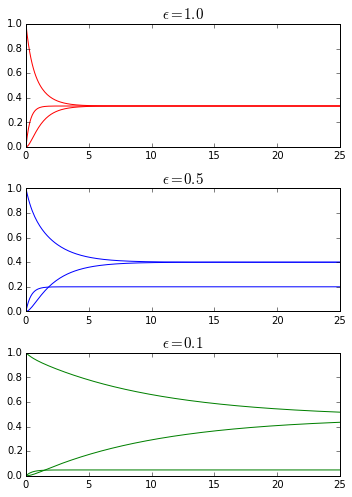

In [3]:
## A simple three compartment model to illustrate the bottleneck effect
def bottleneck_model(g=1.0,e=0.01):
    """
    A three compartment model with a bottleneck. The middle compartment has
    large influx rate constants (g) relative to efflux rate constants (e).
    That is, g >> e.
    """
    A = np.array([[-e,      g,      0],
                  [+e ,  -2*g,     +e],
                  [  0,     g,     -e]])
    return A

## Three example traces, showing a bottleneck as e approaches zero
plt.figure(figsize=(5,7))
plt.subplot(311)
t,u,u_ss,min_eig = run_sim(bottleneck_model(e=1.0),dt=0.1,tmax=25)
plt.plot(t,u,'-r')
plt.xlim([t[0],t[-1]])
plt.title('$\epsilon = 1.0$',fontsize=15)

plt.subplot(312)
t,u,u_ss,min_eig = run_sim(bottleneck_model(e=0.5),dt=0.1,tmax=25)
plt.plot(t,u,'-b')
plt.xlim([t[0],t[-1]])
plt.title('$\epsilon = 0.5$',fontsize=15)

plt.subplot(313)
t,u,u_ss,min_eig = run_sim(bottleneck_model(e=0.1),dt=0.1,tmax=25)
plt.plot(t,u,'-g')
plt.xlim([t[0],t[-1]])
plt.title('$\epsilon = 0.1$',fontsize=15)

plt.tight_layout()
plt.savefig('bottleneck_trajectories.svg')
plt.show()

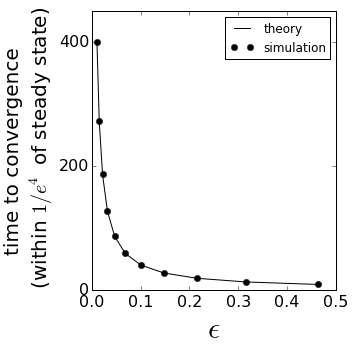

In [21]:
## General analysis for three compartment example
ee = np.logspace(-2,0,13) 
tmax = []
min_eig = []
for eps in ee[:-2]:
    t,u,u_ss,minimum_eig = run_sim(bottleneck_model(e=eps),dt=0.1)
    tmax.append(t[-1])
    min_eig.append(minimum_eig)

plt.figure(figsize=(5,5))
ax = plt.subplot(111)
plt.plot(ee[:-2],-4/(np.array(min_eig)),'-k',label='theory')
plt.plot(ee[:-2],tmax,'ok',label='simulation')
plt.yticks([0,200,400])
plt.legend()
plt.xlabel('$\epsilon$',fontsize=30)
plt.ylabel('time to convergence \n (within $1/e^4$ of steady state)',fontsize=20)
for item in ax.get_xticklabels()+ax.get_yticklabels():
    item.set_fontsize(16)
plt.tight_layout()
plt.savefig('bottleneck_theory.svg')
plt.show()